<a href="https://colab.research.google.com/github/prakhar-chaurasiya/ml/blob/main/Covariance_Matrix_Prediction_Improved_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Previous Notebook : https://colab.research.google.com/drive/1eFiLFNzFT4cmoKhv5nCGBrQoK9hsO8dh

This model is trained for longer duration on different pairs of stocks.

In [ ]:
# Importing libraries
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, Reshape, TimeDistributed, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Data from ProwessIQ for 22 Years
!wget -O nifty_data.csv https://drive.google.com/uc?id=1rTI-ZcI2PiwGSKchh4krpzvcgUzUK-WW&export=download

data = pd.read_csv('nifty_data.csv', parse_dates={'dt':['Slot Date']}, index_col='dt', na_values=[' '],dtype=np.float64)

# Those stocks those are present in NIFTY50 ever since 2000.
stocks_of_interest = []
for col in data.columns:
  if data[col].isna().sum() < 7:
    stocks_of_interest.append(col) 
	
stocks = data[stocks_of_interest].copy()
stocks.fillna(method='bfill', inplace=True)
stocks_daily_return = stocks.pct_change()
stocks_daily_return.dropna(inplace=True)

def random_portfolio(k):
  return random.sample(stocks_of_interest, k)

days = 250 
covar_shape = 2
timestamp, features = days, covar_shape
def train_test_from_random_port(covar_shape, print_stocks=True):
  p = random_portfolio(covar_shape)
  portfolio = stocks_daily_return[p].copy()
  portfolio_closing = stocks[p].iloc[1:].copy()

  X_temp = []
  y_temp = []
  d = portfolio.shape[0]

  for n in range(d-days+1):
    r_x = portfolio.iloc[n:n+days].values # [0: 250] 250 days
    r_y = portfolio.iloc[n+1:n+days+1].values # [1: 251] 250 days
    c = np.cov(r_y.T) # Var-Covar for 251th day
    X_temp.append(r_x)
    y_temp.append(c*1000)
  X = np.array(X_temp)
  y = np.array(y_temp)

  X_train = X[:round(X.shape[0]*0.8)].copy()
  y_train = y[:round(X.shape[0]*0.8)].copy()
  X_test = X[round(X.shape[0]*0.8):].copy()
  y_test = y[round(X.shape[0]*0.8):].copy()

  if print_stocks:
    print()
    print('Training on: ', end='')
    print(*p, sep=', ')
    print()

  return X_train, y_train, X_test, y_test

# CNN + RNN + DNN model
model_cnn_lstm = Sequential()
model_cnn_lstm.add(Conv1D(128, 3, activation='relu', input_shape=(timestamp, features)))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(Conv1D(128, 3, activation='relu', input_shape=(timestamp, features)))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(LSTM(units = 64, return_sequences = True))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(LSTM(units = 64, return_sequences = False))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(Dense(64, activation=tf.keras.activations.tanh))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(Dense((covar_shape*covar_shape)))
model_cnn_lstm.add(Reshape((covar_shape, covar_shape)))
model_cnn_lstm.summary()

model_cnn_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

full_training_loss_history = []
for i in range(100):
  print()
  print(f'---------------------------Iteration {i+1}---------------------------')
  X_train, y_train, X_test, y_test = train_test_from_random_port(covar_shape) 
  history_cnn_lstm = model_cnn_lstm.fit(X_train, y_train, epochs=10)
  full_training_loss_history.extend(history_cnn_lstm.history['loss'])

model_cnn_lstm.evaluate(X_test, y_test)

print(f'\nPredicted:\n{model_cnn_lstm.predict(X_test[-1:])}')
print(f'\nActual:\n{y_test[-1:]}')

--2022-08-12 11:10:24--  https://drive.google.com/uc?id=1rTI-ZcI2PiwGSKchh4krpzvcgUzUK-WW
Resolving drive.google.com (drive.google.com)... 172.217.204.138, 172.217.204.101, 172.217.204.102, ...
Connecting to drive.google.com (drive.google.com)|172.217.204.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-98-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8o3o7nk3b32jp7ud730sqc24d3j0td4o/1660302600000/01508963693596524949/*/1rTI-ZcI2PiwGSKchh4krpzvcgUzUK-WW?uuid=4c4ec9e2-cda4-4062-ac0f-ae19cf9d510f [following]
--2022-08-12 11:10:25--  https://doc-0k-98-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8o3o7nk3b32jp7ud730sqc24d3j0td4o/1660302600000/01508963693596524949/*/1rTI-ZcI2PiwGSKchh4krpzvcgUzUK-WW?uuid=4c4ec9e2-cda4-4062-ac0f-ae19cf9d510f
Resolving doc-0k-98-docs.googleusercontent.com (doc-0k-98-docs.googleusercontent.com)... 172.217.203.132, 2607:f8b0:400c:c07::84
Connecting to d

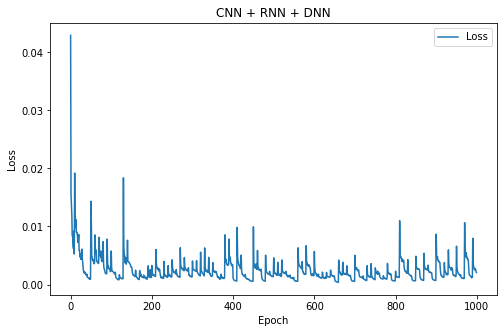

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(full_training_loss_history, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='top left')
plt.title('CNN + RNN + DNN')
plt.show()

Randomly choose the pair and compare results.

In [ ]:
X_train, y_train, X_test, y_test = train_test_from_random_port(covar_shape) 
model_cnn_lstm.evaluate(X_test, y_test)

print(f'\nPredicted:\n{model_cnn_lstm.predict(X_test[-1:])}')
print(f'\nActual:\n{y_test[-1:]}')


Training on: Indusind Bank Ltd., Britannia Industries Ltd.

34/34 [==============================] - 0s 6ms/step - loss: 0.0399 - mae: 0.0958

Predicted:
[[[0.5872837  0.06449406]
  [0.06449406 0.2197736 ]]]

Actual:
[[[0.58377522 0.08446877]
  [0.08446877 0.20488618]]]


In [ ]:
model_cnn_lstm.save('CNN_LSTM.h5')